<center><h1><b><mark style="background-color: #ff1493; color: black;">IP CW Final</mark></b></h1></center>


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import contingency_table as cont
import imageio
from skimage import morphology
from skimage.segmentation import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.measure import regionprops, label


def convert_BW(img):
    
    # converts the image to grayscale
    
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_bw

def negation(img):
    # Ensure the image is in uint8 format
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    negated_image = 255 - img
    return negated_image

def inc_gain(img,gain_factor):
    scaled_image = img * gain_factor
    scaled_image[scaled_image > 255] = 255
    return scaled_image

def histogramEq(img):
    # Convert the input image to a supported depth format (e.g., 8-bit)
    img = img.astype(np.uint8)

    # Convert the input image to grayscale if it's in color
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    # Apply histogram equalization
    eq_img = cv2.equalizeHist(gray_img)

    return eq_img

def otsu_threshold(img):
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    
    if gray_img.dtype != 'uint8':
        gray_img = gray_img.astype('uint8')
    _, otsu_threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return otsu_threshold

def gamma_Correction(img, g):
    gamma = g
    gamma_img = ((img / 255) ** gamma) * 255
    gamma_img = gamma_img.astype("uint8")
    return gamma_img

def erosion(binary_image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    return eroded_image

def dilation(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    return dilated_image
 
def extract_foreground(image): 
    if image.dtype != 'uint8':
        image = image.astype('uint8')
    height, width = image.shape[:2]
    mask = np.zeros(image.shape[:2], np.uint8)
    rectangle = (1, 1, width, height)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    cv2.grabCut(image, mask, rectangle, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT) # 5
    foreground_mask = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(image, image, mask=foreground_mask)
    return foreground


def sharpen_img(image, strength=1.5, sigma=1.0):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def roi(binary_image):
    #inverted_image = np.logical_not(binary_image) # invert colors of binary image
    labeled_image = label(binary_image)# Label connected components in the inverted binary image
    regions = regionprops(labeled_image)# calculate properties of labeled regions
    largest_label = max(regions, key=lambda region: region.area).label# find label of largest component
    largest_black_blob_mask = labeled_image == largest_label# mask containing only the largest component (black blob)
    largest_black_blob_image = np.zeros_like(binary_image)# mask to the inverted binary image to obtain the largest black blob
    largest_black_blob_image[largest_black_blob_mask] = 1
    return largest_black_blob_image

def calculate_ssim(ground_truth, final):
    print(ground_truth.shape)
    print(final.shape)
    similarity = ssim(ground_truth, final, channel_axis=None)
    return similarity

def calculate_miou(ground_truth, final):
    # Calculates the Intersection over Union (IoU) for the foreground class (class 1)  
    intersection = np.logical_and(final == 1, ground_truth == 1)  
    union = np.logical_or(final == 1, ground_truth == 1)  
    iou_class1 = np.sum(intersection) / np.sum(union)  

    # Calculates the IoU for the background class (class 0)  
    intersection_bg = np.logical_and(final == 0, ground_truth == 0)  
    union_bg = np.logical_or(final == 0, ground_truth == 0)  
    iou_class0 = np.sum(intersection_bg) / np.sum(union_bg)  

    # Calculates mIoU as the mean of class IoU values  
    miou = (iou_class1 + iou_class0) / 2
    
    return miou

# customizable function to apply all processing functions to image
def image_pipeline(img,ground):

    bw_img = convert_BW(img)
    gamma_img= gamma_Correction(bw_img,3)
    foreground_img = extract_foreground(gamma_img)
    negated_img = negation(foreground_img)  
    hist_eq_img = histogramEq(negated_img)
    otsu_thresh_img = otsu_threshold(hist_eq_img)
    negated_img2 = negation(otsu_thresh_img)
    final_img = roi(negated_img2)
    
    _, ground_t = cv2.threshold(convert_BW(ground), 50, 255, cv2.THRESH_BINARY)
    ground_t = erosion(negation(ground_t),10)
    ground_t = ground_t // 255
    
    print("similarity index: ",calculate_ssim(ground_t,final_img))
    print("miou: ",calculate_miou(ground_t,final_img))
    
    # display half-processed images
    images = [bw_img, gamma_img, foreground_img, negated_img, hist_eq_img, otsu_thresh_img,negated_img2, final_img, ground_t]
    titles = ["bw","gamma", "fground", "negate","histogram equalisation", "otsu threshold","negated2", "final", "ground_t"]
    fig, axes = plt.subplots(3, 4, figsize=(15, 9))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [2]:
def display_pipeline(image_pipeline):

    file_names = ["easy","medium","hard"]
    input_file_directory = "C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\input_images\\"
    ground_truth_directory =  "C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\ground_truths\\"
    
    for j in file_names:
        
        first_file_directory = input_file_directory+j+"\\"+j+"_"+"1"+".jpg"
        sec_file_directory = input_file_directory+j+"\\"+j+"_"+"2"+".jpg"
        third_file_directory = input_file_directory+j+"\\"+j+"_"+"3"+".jpg"
        
        ground1=ground_truth_directory+j+"\\"+j+"_"+"1"+".png"
        ground2=ground_truth_directory+j+"\\"+j+"_"+"2"+".png"
        ground3=ground_truth_directory+j+"\\"+j+"_"+"3"+".png"

        # getting input images
        image1=cv2.imread(first_file_directory, cv2.IMREAD_COLOR)
        image2=cv2.imread(sec_file_directory, cv2.IMREAD_COLOR)
        image3=cv2.imread(third_file_directory, cv2.IMREAD_COLOR)

        # getting all processed images
        gimage1=cv2.imread(ground1, cv2.IMREAD_COLOR)
        gimage2=cv2.imread(ground2, cv2.IMREAD_COLOR)
        gimage3=cv2.imread(ground3, cv2.IMREAD_COLOR)
        
        # getting final images
        fimage1=image_pipeline(image1,gimage1)
        fimage2=image_pipeline(image2,gimage2)
        fimage3=image_pipeline(image3,gimage3)

(500, 666)
(500, 666)
similarity index:  0.9971933148932631
miou:  0.9170246781194393


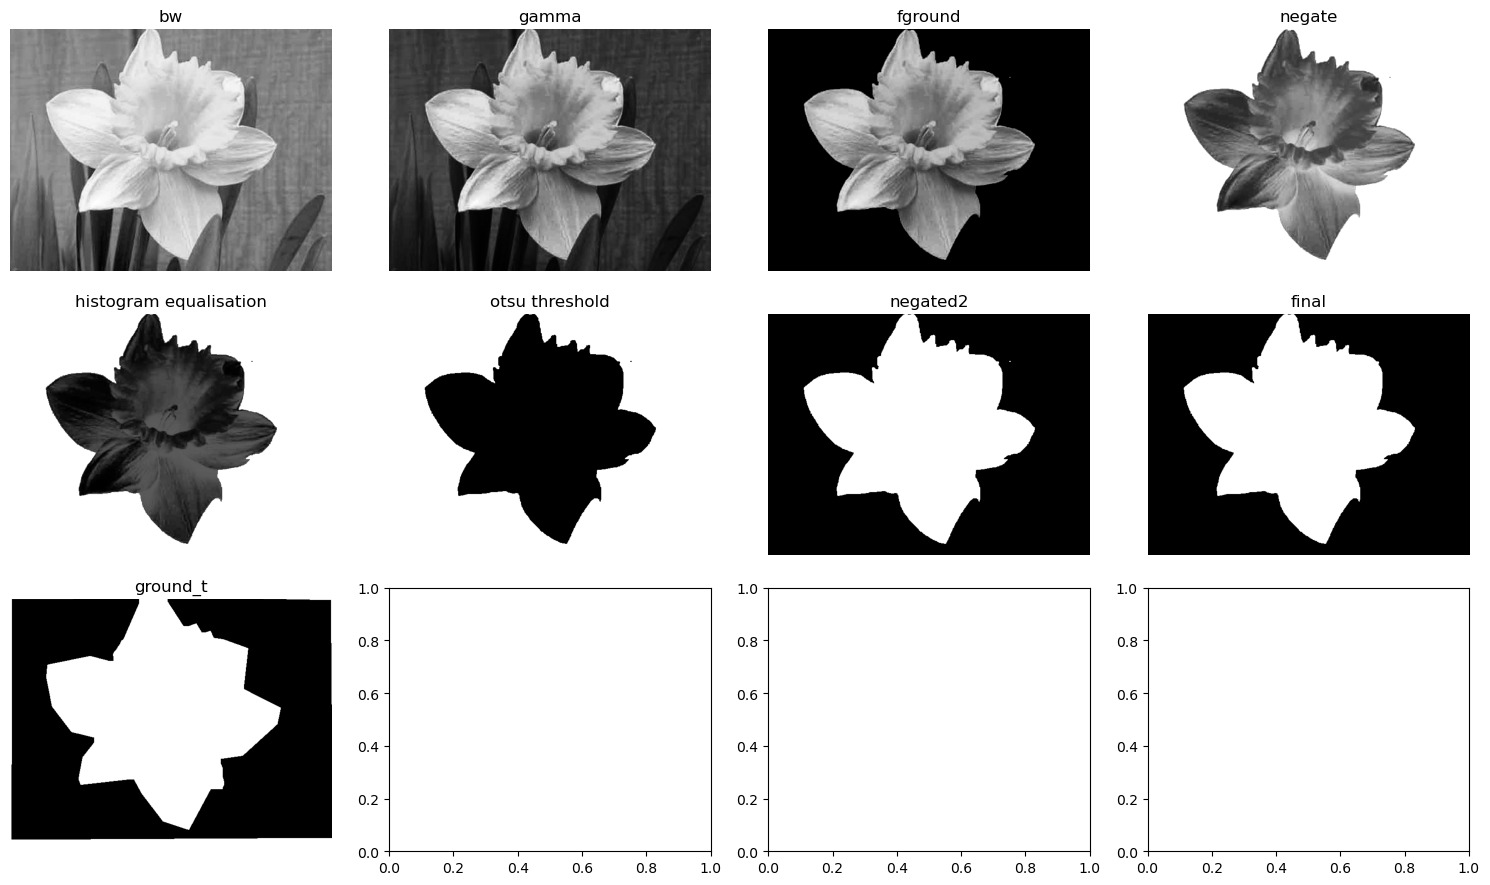

(500, 666)
(500, 666)
similarity index:  0.990822945689661
miou:  0.8307955954446169


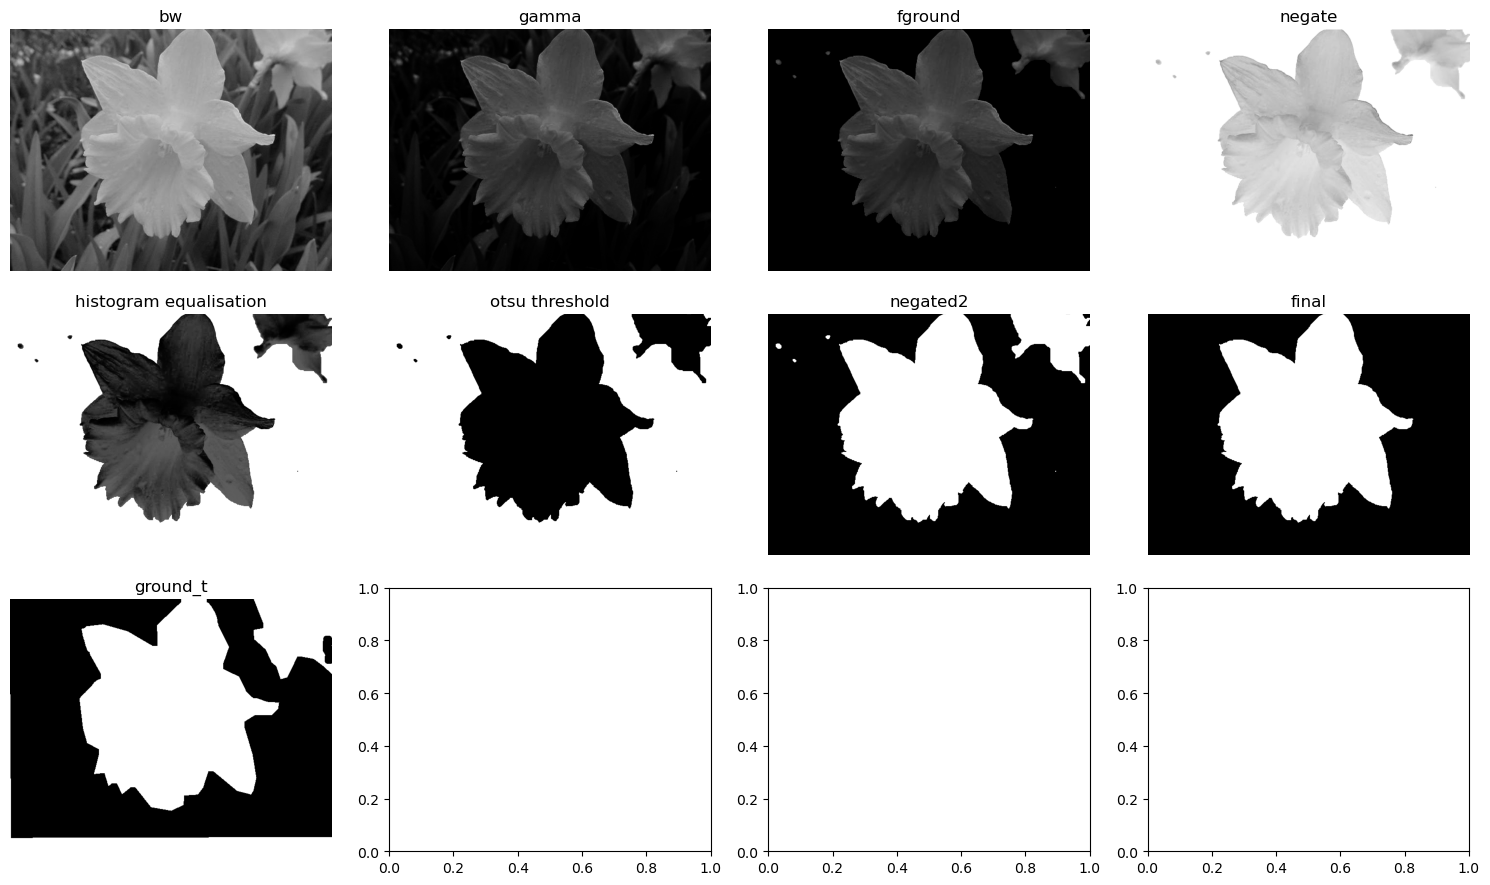

(500, 666)
(500, 666)
similarity index:  0.9972580346379702
miou:  0.9221098467179056


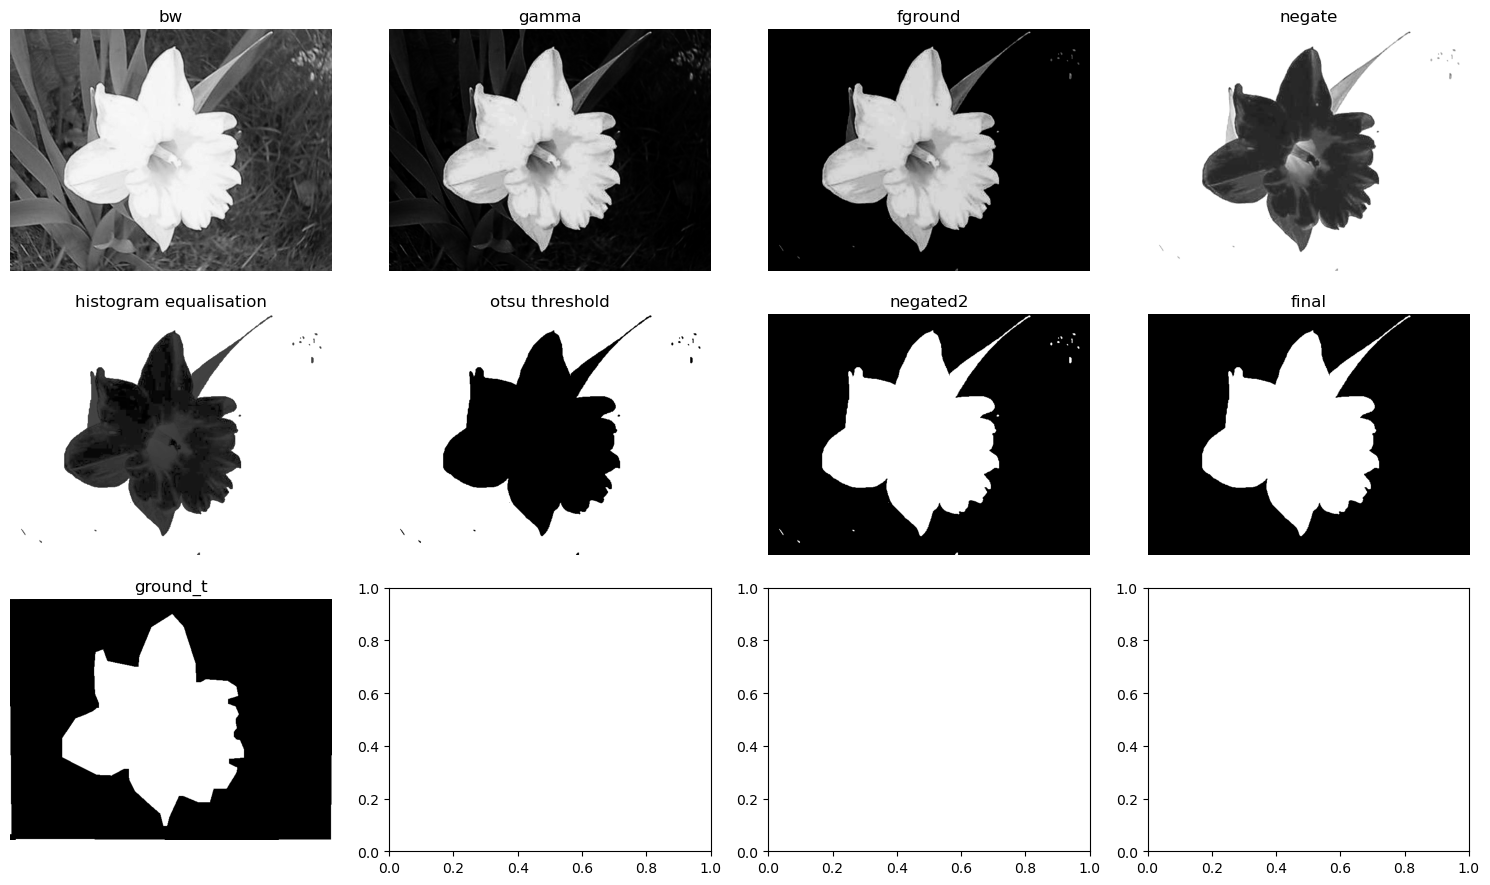

(529, 500)
(529, 500)
similarity index:  0.9884125068429004
miou:  0.8034857787754561


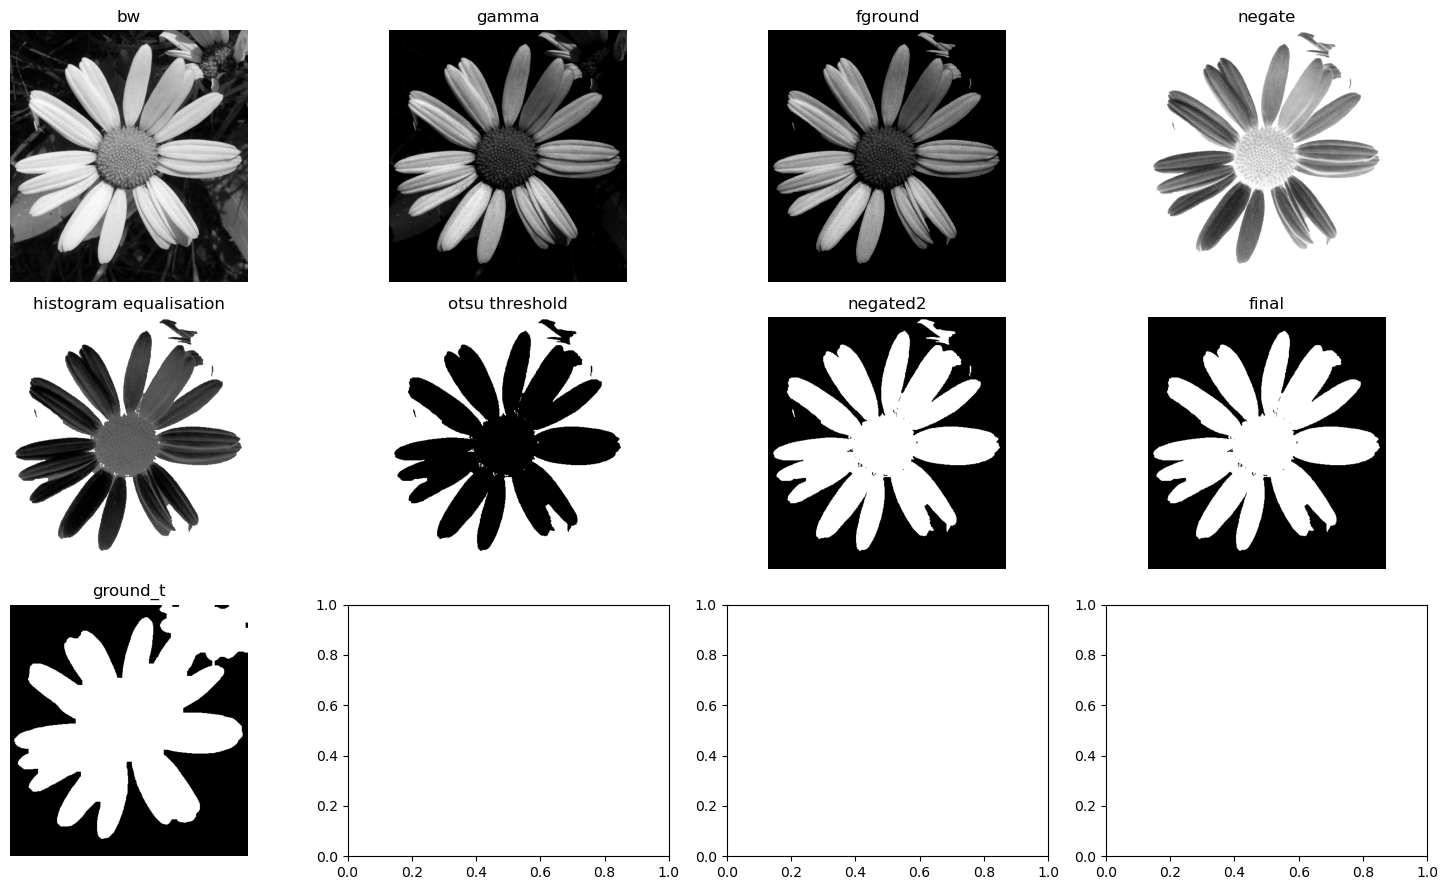

(500, 750)
(500, 750)
similarity index:  0.995853578348066
miou:  0.9209537790613742


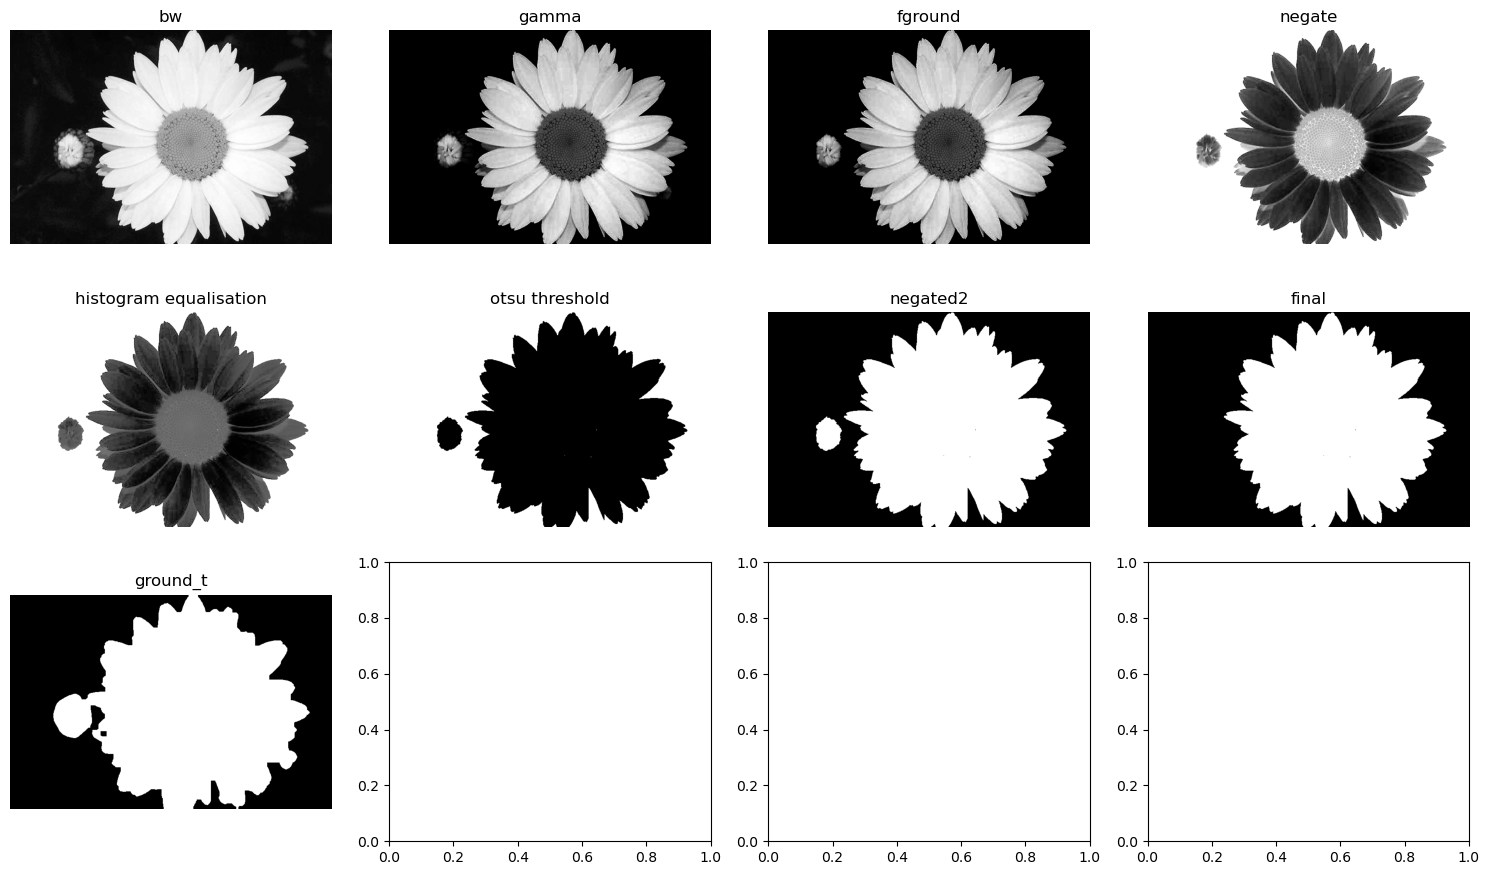

(500, 538)
(500, 538)
similarity index:  0.9961945962726315
miou:  0.9100735413152571


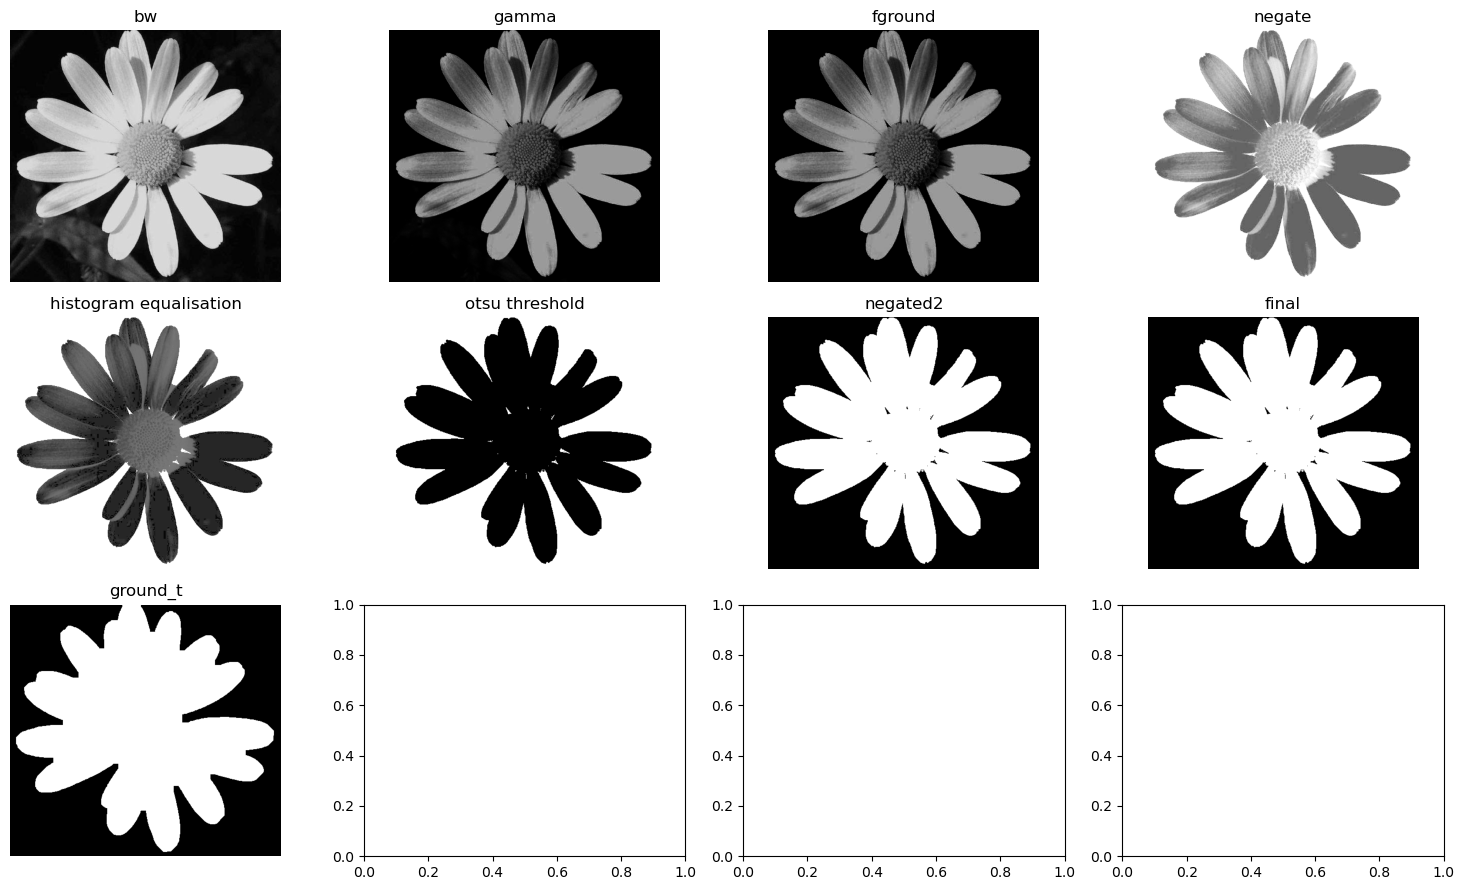

(500, 518)
(500, 518)
similarity index:  0.9988747422493451
miou:  0.9619121697790404


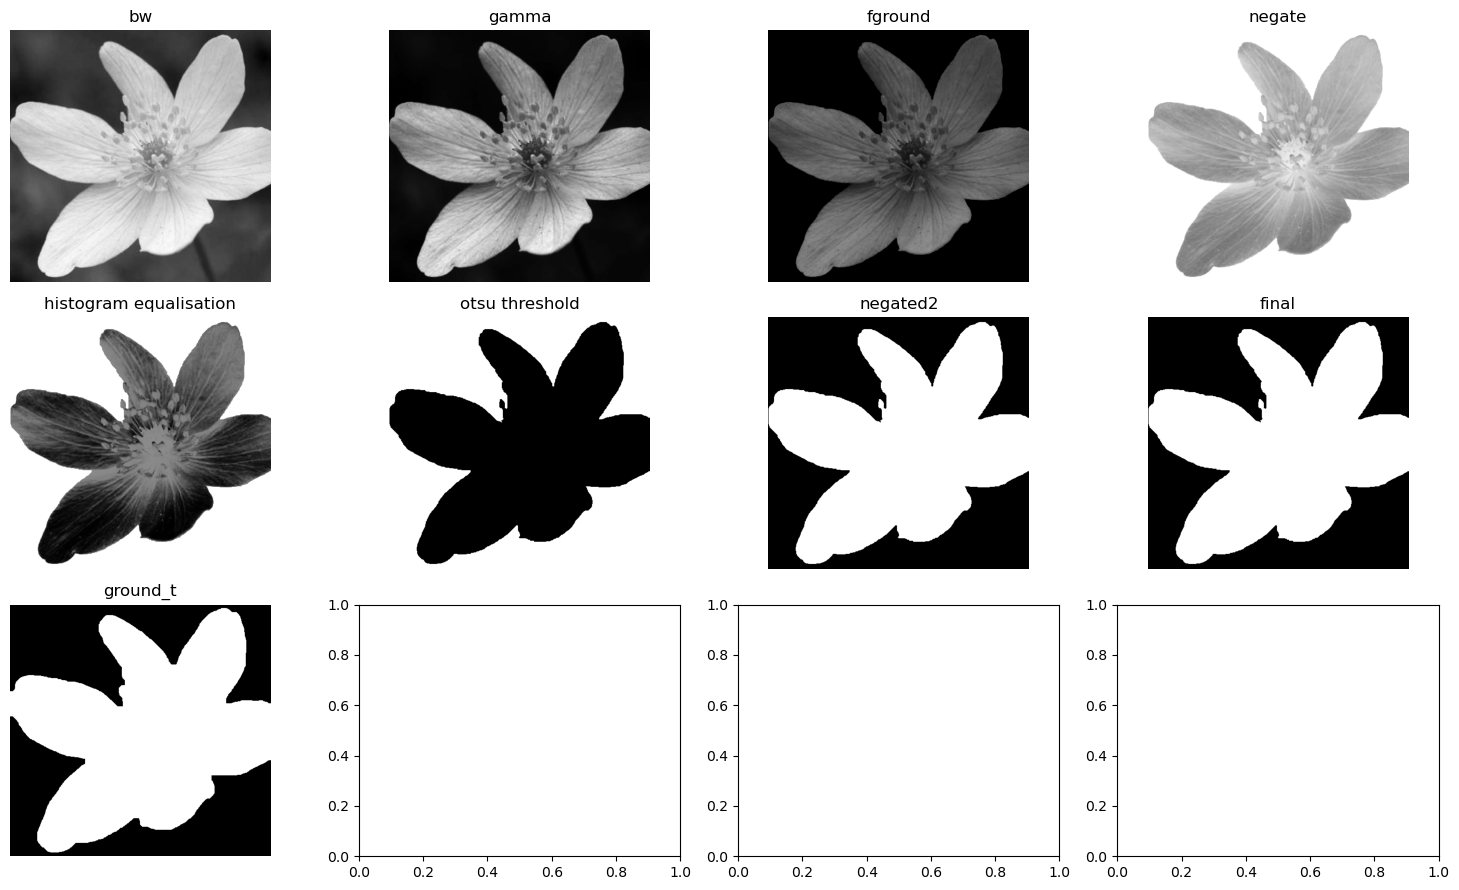

(500, 600)
(500, 600)
similarity index:  0.9977585352085737
miou:  0.9485774143296821


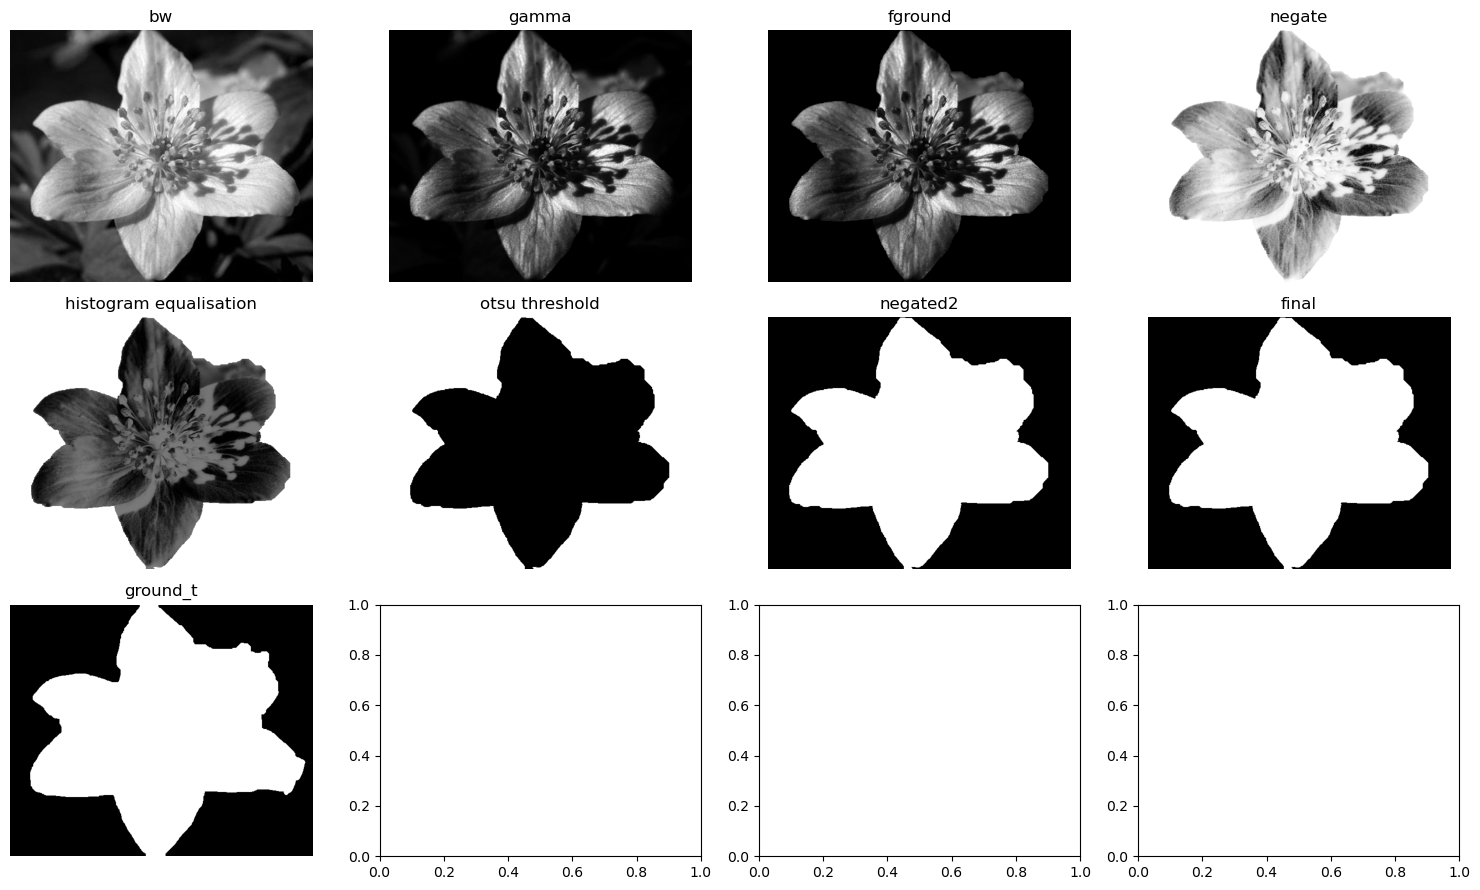

(500, 500)
(500, 500)
similarity index:  0.9991690462850693
miou:  0.9713700729765606


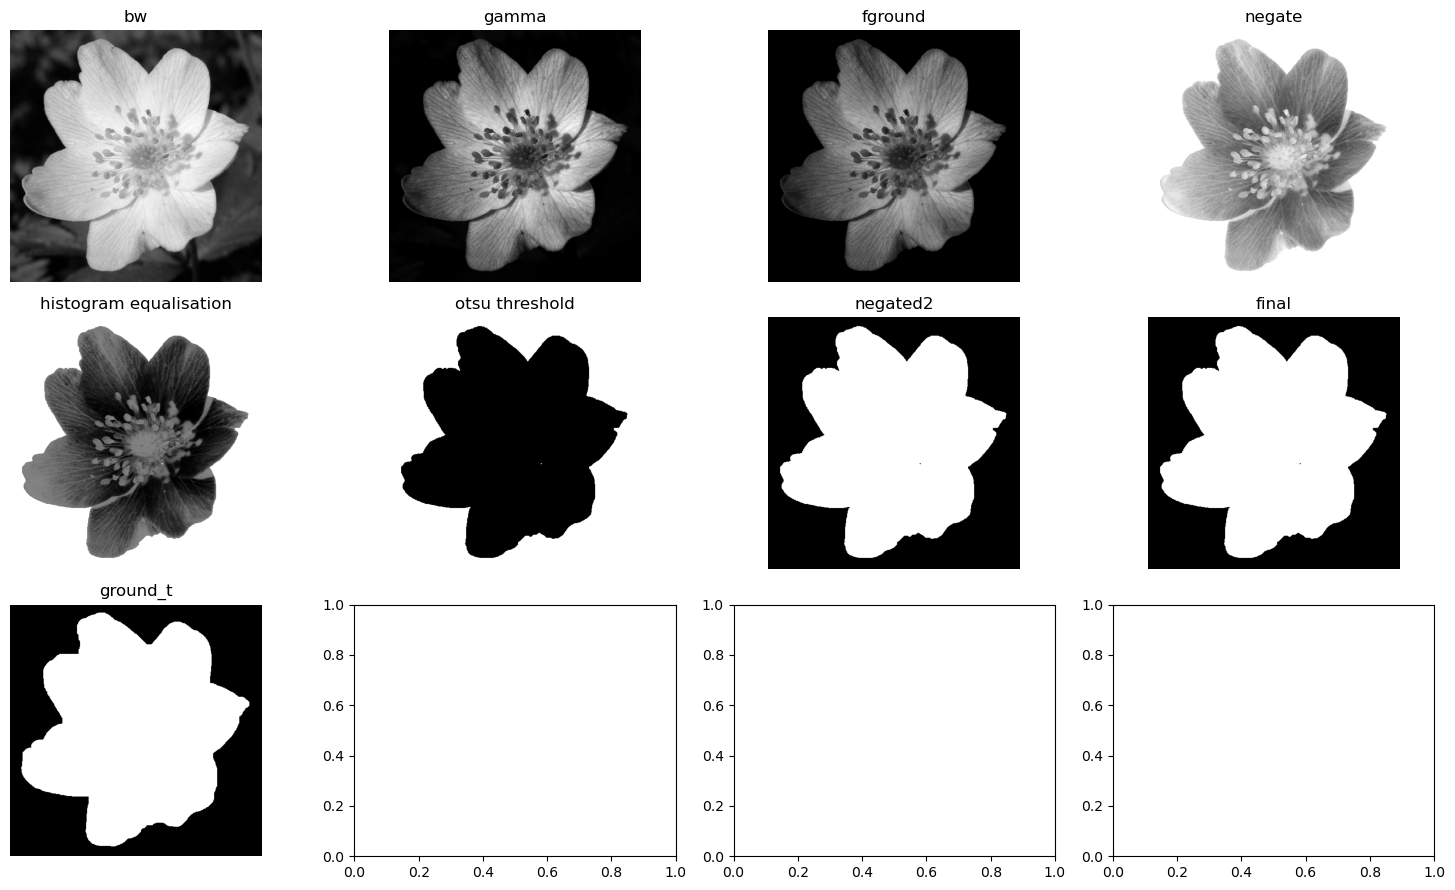

In [5]:
display_pipeline(image_pipeline)